<a href="https://colab.research.google.com/github/1kaiser/-DEM-30m-90m-srtm/blob/main/Serial_MLP_Image_Train_Inference_JAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**setting up the data pipeline**

In [ ]:
import tensorflow as tf
import pathlib
dir='/content/files'
urls = 'https://github.com/1kaiser/Snow-cover-area-estimation/releases/download/v1/imagesfolder.zip'
data_dir = tf.keras.utils.get_file(origin=urls,
                                   fname='s',
                                   cache_subdir= dir,
                                   archive_format='auto',
                                   untar=False,
                                   extract=True)
!rm -r {dir}/s
data_dir = pathlib.Path(data_dir)

GeoTiff to Image & Image to Geotiff conversion


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os.path
import re

from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

def get_gain_band(input_file):
    """get GAIN_BAND from meta file (*.tif.txt)"""
     # define file name of *.tif.txt
    ifile_txt = re.sub(r'.tif', '.tif.txt', input_file)
    ld = open(ifile_txt)
    lines = ld.readlines()
    ld.close()
    
    gain_band = []
    for line in lines:
        if line.find("GAIN_BAND") >= 0:
             gain_band.append(float((re.split(' ', line)[1]).strip()))
    return gain_band

def tif2array(input_file, calc_gain=True):
    """
    read GeoTiff and convert to numpy.ndarray.
    Inputs:
        input_file (str) : the name of input GeoTiff file.
        calc_gain (bool) : wheter calc GAIN to DN  or not (defaul:True).
    return:
        image(np.array) : image for each bands
        dataset : for gdal's data drive.
    """
    dataset = gdal.Open(input_file, gdal.GA_ReadOnly)
    # Allocate our array using the first band's datatype
    image_datatype = dataset.GetRasterBand(1).DataType
    image = np.zeros((dataset.RasterYSize, dataset.RasterXSize, dataset.RasterCount),
                     dtype=float)
    
    if calc_gain == True:
        # get gain
        gain = get_gain_band(input_file)
    
    # Loop over all bands in dataset
    for b in range(dataset.RasterCount):
        # Remember, GDAL index is on 1, but Python is on 0 -- so we add 1 for our GDAL calls
        band = dataset.GetRasterBand(b + 1)
        # Read in the band's data into the third dimension of our array
        if calc_gain == True:
            # calc gain value for each bands
            image[:, :, b] = band.ReadAsArray() * gain[b]
        else:
            image[:, :, b] = band.ReadAsArray()
    return image, dataset

def array2raster(newRasterfn, dataset, array, dtype):
    """
    save GTiff file from numpy.array
    input:
        newRasterfn: save file name
        dataset : original tif file
        array : numpy.array
        dtype: Byte or Float32.
    """
    cols = array.shape[1]
    rows = array.shape[0]
    originX, pixelWidth, b, originY, d, pixelHeight = dataset.GetGeoTransform() 

    driver = gdal.GetDriverByName('GTiff')

    # set data type to save.
    GDT_dtype = gdal.GDT_Unknown
    if dtype == "Byte": 
        GDT_dtype = gdal.GDT_Byte
    elif dtype == "Float32":
        GDT_dtype = gdal.GDT_Float32
    else:
        print("Not supported data type.")

    # set number of band.
    if array.ndim == 2:
        band_num = 1
    else:
        band_num = array.shape[2]

    outRaster = driver.Create(newRasterfn, cols, rows, band_num, GDT_dtype)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))

    # # Loop over all bands.
    # for b in range(band_num):
    #     outband = outRaster.GetRasterBand(b + 1)
    #     # Read in the band's data into the third dimension of our array
    #     if band_num == 1:
    #         outband.WriteArray(array)
    #     else:
    #         outband.WriteArray(array[:,:,b])
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array.reshape(rows, cols))
    # setting srs from input tif file.
    prj=dataset.GetProjection()
    outRasterSRS = osr.SpatialReference(wkt=prj)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()
    return newRasterfn

In [ ]:
image_dir = r'/content/files/'

#############################################################################
prefix = "sur_refl_"
end = ["b01", "b02", "b03", "b04", "b05", "b06", "b07", "day_of_year", "qc_500m", "raz", "state_500m", "szen", "vzen"]
DayOY = "_doy\[0-9]+_aid0001"
fileExt = r'.tif'
expression_b1 = prefix+end[0]
expression_b2 = prefix+end[1]
expression_b3 = prefix+end[2]
expression_b4 = prefix+end[3]
expression_b5 = prefix+end[4]
expression_b6 = prefix+end[5]
expression_b7 = prefix+end[6]


imgs_list_b1 = [f for f in os.listdir(image_dir) if f.__contains__(expression_b1)]

imgs_list_b1.sort(reverse=True)                     #<<<< to start file streaming from the last date 2022 >> 2021 >> 2020 ....


In [ ]:
from google.colab import output
temp_dir = r'/content/'
def ybatchedimages(images_path, image_list, batch_idx):
  images = []
  for id in range(len(batch_idx)):
    path = os.path.join(images_path, image_list[id])
    pathb2 = path.replace(expression_b2, expression_b2)
    pathb4 = path.replace(expression_b2, expression_b4)
    pathb6 = path.replace(expression_b2, expression_b6)

    #creating file NDSI
    !gdal_calc.py \
      --overwrite \
      --type=Float32 \
      -A {pathb4} \
      --A_band 1 \
      -B {pathb6} \
      --B_band 1 \
      --outfile={temp_dir}"NDSI_result.tif" \
      --calc="(A.astype(float) - B)/(A.astype(float) + B)"

    !gdal_calc.py \
      --overwrite \
      --type=Float32 \
      -A {pathb2} \
      --A_band 1 \
      -B {temp_dir}"NDSI_result.tif" \
      --B_band 1 \
      --outfile={temp_dir}"BothCheck_result.tif" \
      --calc="(B.astype(float)>=0.4)*(A.astype(float)>0.11*A.astype(float))"#--calc="(A.astype(float)>0.011*A.astype(float))"#

    pathout = temp_dir+str('BothCheck_result.tif')
    images.append(normalize(tif2array(pathout, 0)[0]))
    !rm -r {temp_dir}"NDSI_result.tif"
    !rm -r {temp_dir}"BothCheck_result.tif"
    output.clear()
  return images


def normalize(arr):
    ''' Function to normalize an input array to 0-1 '''
    arr_min = arr.min()
    arr_max = arr.max()
    return (arr - arr_min) / (arr_max - arr_min)


import jax.numpy as jnp
def batchedimages(images_path, image_list, batch_idx):
  images = []
  for id in range(len(batch_idx)):
    path = os.path.join(images_path, image_list[id])
    v1 = normalize(tif2array(path.replace(expression_b2, expression_b1),0)[0])
    v2 = jnp.append(v1, normalize(tif2array(path.replace(expression_b2, expression_b2),0)[0]) , axis =2)
    v3 = jnp.append(v2, normalize(tif2array(path.replace(expression_b2, expression_b3),0)[0]) , axis =2)
    v4 = jnp.append(v3, normalize(tif2array(path.replace(expression_b2, expression_b4),0)[0]) , axis =2)
    v5 = jnp.append(v4, normalize(tif2array(path.replace(expression_b2, expression_b5),0)[0]) , axis =2)
    v6 = jnp.append(v5, normalize(tif2array(path.replace(expression_b2, expression_b6),0)[0]) , axis =2)
    v7 = jnp.append(v6, normalize(tif2array(path.replace(expression_b2, expression_b7),0)[0]) , axis =2)
    images.append(v7)
    w1 = tif2array(path.replace(expression_b2, expression_b1),0)[0]
    w2 = tif2array(path.replace(expression_b2, expression_b2),0)[0]
    w3 = tif2array(path.replace(expression_b2, expression_b3),0)[0]
    w4 = tif2array(path.replace(expression_b2, expression_b4),0)[0]
    w5 = tif2array(path.replace(expression_b2, expression_b5),0)[0]
    w6 = tif2array(path.replace(expression_b2, expression_b6),0)[0]
    w7 = tif2array(path.replace(expression_b2, expression_b7),0)[0]
  return images

import jax.random as random
import jax.numpy as jnp
batch_size = 1
no_of_batches = int(len(imgs_list_b1)/batch_size)
def data_stream():
  key = random.PRNGKey(0)
  perm = random.permutation(key, len(imgs_list_b1))
  x_img_list = []
  y_img_list = []
  for i in range(no_of_batches):
    batch_idx = perm[i * batch_size : (i + 1) * batch_size]; #print(batch_idx)
    # x_img_list.append(batchedimages(x_total_images_path, batch_idx))
    # y_img_list.append(batchedimages(y_total_images_path, batch_idx))
    yield jnp.asarray(batchedimages(image_dir, imgs_list_b1, batch_idx)), jnp.asarray(ybatchedimages(image_dir, imgs_list_b1, batch_idx))

## **RUN 2 testing** 

**Model and training code**
Our model is a coordinate-based multilayer perceptron. In this example, for each input image coordinate $(x,y)$, the model predicts the associated color $(r,g,b)$ or any $(gray)$.

![Network diagram](https://user-images.githubusercontent.com/3310961/85066930-ad444580-b164-11ea-9cc0-17494679e71f.png)

**POSITIONAL ENCODING BLOCK** 

In [ ]:
#✅
import jax
import jax.numpy as jnp


positional_encoding_dims = 6  # Number of positional encodings applied

def positional_encoding(args):
    image_height_x_image_width, cha = args.shape
    inputs_freq = jax.vmap(lambda x: args * 2.0 ** x)(jnp.arange(positional_encoding_dims))
    x = jnp.stack([jnp.sin(inputs_freq), jnp.cos(inputs_freq)])
    x = x.swapaxes(0, 2)
    x = x.reshape([image_height_x_image_width, -1])
    x = jnp.concatenate([args, x], axis=-1)
    return x

def batch_encoded(args):
    img_list = []
    for i in range(args.shape[0]):
        c = args[i]
        c = c.reshape(-1, c.shape[2])
        p = positional_encoding(c)
        img_list.append(p.reshape(args.shape[1],args.shape[2],p.shape[1]))
        x = jnp.array(img_list)
    return x



**MLP MODEL DEFINATION**
Basically, passing input points through a simple Fourier Feature Mapping enables an MLP to learn high-frequency functions (such as an RGB image) in low-dimensional problem domains (such as a 2D coordinate of pixels).

In [ ]:
#✅
!python -m pip install -qq -U flax orbax
# Orbax needs to enable asyncio in a Colab environment.
!python -m pip install -qq nest_asyncio


import jax
import jax.numpy as jnp

import flax
import optax
from typing import Any

from jax import lax
import flax.linen as nn
from flax.training import train_state, common_utils

apply_positional_encoding = True # Apply posittional encoding to the input or not
ndl = 8 # num_dense_layers Number of dense layers in MLP
dlw = 256 # dense_layer_width Dimentionality of dense layers' output space 

##########################################<< MLP MODEL >>#########################################
class MLPModel(nn.Module):
    dtype: Any = jnp.float32
    precision: Any = lax.Precision.DEFAULT
    apply_positional_encoding: bool = apply_positional_encoding
    @nn.compact
    def __call__(self, input_points):
      x = batch_encoded(input_points) if self.apply_positional_encoding else input_points
      for i in range(ndl):
          x = nn.Dense(dlw,dtype=self.dtype,precision=self.precision)(x)
          x = nn.relu(x)
          x = jnp.concatenate([x, input_points], axis=-1) if i == 4 else x
      x = nn.Dense(1, dtype=self.dtype, precision=self.precision)(x)
      return x
##########################################<< MLP MODEL >>#########################################

**initialize the module**

In [ ]:
#✅
!python -m pip install -q -U flax
import optax
from flax.training import train_state
import jax.numpy as jnp
import jax


def Create_train_state(r_key, model, shape, learning_rate ) -> train_state.TrainState:
    print(shape)
    variables = model.init(r_key, jnp.ones(shape)) 
    optimizer = optax.adam(learning_rate) 
    return train_state.TrainState.create(
        apply_fn = model.apply,
        tx=optimizer,
        params=variables['params']
    )

learning_rate = 1e-4
model = MLPModel() # Instantiate the Model

**kernel visualization of the model being used**

In [ ]:
def VisualizeKernel(state_parameters, epochs):
  import cv2
  from google.colab.patches import cv2_imshow
  import numpy as np
  params = state_parameters
  a = []
  for i in params:
    kernel = params[str(i)]['kernel']
    a.append(np.array(kernel))

  import numpy as np
  import matplotlib.pyplot as plt

  rangex = len(params.keys())

  fig, axs = plt.subplots(2, int(rangex/2)+1, figsize=(20,20))
  images = [params[str(i)]['kernel'] for i in params]
  for i, ax in enumerate(axs.flatten()):
      if i < len(images):
          ax.imshow(images[i], cmap='ocean')
      else:
          ax.remove()
  plt.savefig(str(epochs)+'.png', dpi=500)
  plt.show()



**defining loss function**

In [ ]:
#serial
def image_difference_loss(logits, labels):
    loss =  0.5 * jnp.mean((logits - labels) ** 2) 
    return loss
def compute_metrics(*, logits, labels):
  loss = image_difference_loss(logits, labels)
  metrics = {
      'loss': loss,     #LOSS
      'logits': logits, #PREDICTED IMAGE
      'labels': labels  #ACTUAL IMAGE
  }
  return metrics

**train step defination**

In [ ]:
#cpu serial
import jax

def train_step(state: train_state.TrainState, batch: jnp.asarray, rng):
    image, label = batch  
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, image);
        loss =  image_difference_loss(logits, label);
        return loss, logits

    gradient_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = gradient_fn(state.params)
    new_state = state.apply_gradients(grads=grads)
    logs = compute_metrics(logits=logits, labels=label)
    return new_state, logs

import jax
@jax.jit
def eval_step(state, image):
    logits = state.apply_fn({'params': state.params}, image)
    return compute_metrics(logits=logits, labels=image)


**image viewing**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np 

def show_image(pimage, oimage, newsize):
  L1 = pimage[0]
  predicted_image = np.array(pimage[0]*255,  dtype=np.uint8).reshape(newsize) # This would be your image array
  original_image = np.array(oimage[0]*255,  dtype=np.uint8).reshape(newsize) # This would be your image array
  a = cv2.vconcat([predicted_image, original_image])

  # for i in range(0,pimage.shape[0]):
  #   predicted_image = np.array(pimage[i]*255,  dtype=np.uint8).reshape(newsize)
  #   original_image = np.array(oimage[i]*255,  dtype=np.uint8).reshape(newsize) # This would be your image array
 
  #   a = cv2.hconcat([a, cv2.vconcat([predicted_image, original_image]))
  cv2_imshow(a)

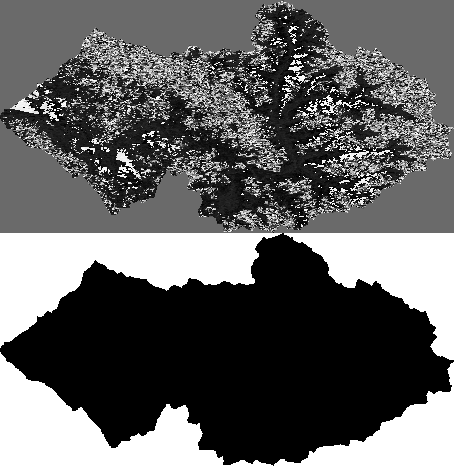


 10%|█         | 2/20 [00:20<03:06, 10.37s/it]

loss:  198.44566  <<< 


In [ ]:
#@title # **👠HIGH HEELS RUN >>>>>>>>>>>** { vertical-output: true }
newsize = (233, 454) #(260, 260) # /.... 233 * 454

import jax
from jax import random
from tqdm import tqdm
import re
from google.colab import output
import orbax.checkpoint as orbax
from flax.training import checkpoints

import optax
import nest_asyncio
nest_asyncio.apply()

rng = jax.random.PRNGKey(0)
CKPT_DIR = 'ckpts'

######################<<<< initiating train state
count = 0
if count == 0 :
  batches = data_stream()
  BATCH, H, W, Channels = next(batches)[0].shape
  state = Create_train_state( rng, model, (BATCH, H, W, Channels ), learning_rate ) 
  count = 1
#✅✅🔻 state = flax.jax_utils.replicate(state)  # FLAX will replicate the state to every device so that updating can be made easy

###################### 
checkpoint_available = 0
pattern = re.compile("checkpoint_\d+")   # to search for "checkpoint_*munerical value*" numerical value of any length is denoted by regular expression "\d+"
dir = "/content/ckpts/"
isFile = os.path.isdir(dir)
if isFile:
  for filepath in os.listdir(dir):
      if pattern.match(filepath):
          checkpoint_available = 1

total_epochs = 20
batches = data_stream()
for epochs in tqdm(range(no_of_batches-5)):  
  

  if checkpoint_available:
    state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
    checkpoint_available = 0 # << Flag updated >>> to stop loading the same checkpoint in the next iteration then remove the checkpoint directory
    !rm -r {dir}

  input_data = next(batches)

  for bbb in tqdm(range(total_epochs)):
    state, metrics = train_step(state, input_data, rng)
    show_image(metrics['logits'], metrics['labels'], newsize)

    # output.clear()
    print("loss: ",metrics['loss']," <<< ") # naming of the checkpoint is "checkpoint_*"  where "*" => value of the steps variable, i.e. 'epochs'
    if (bbb == total_epochs-1) :
      VisualizeKernel(state.params, epochs)

  orbax_checkpointer = orbax.Checkpointer(orbax.PyTreeCheckpointHandler())
  checkpoints.save_checkpoint(ckpt_dir=CKPT_DIR, target=state, step=epochs, prefix='checkpoint_', keep=1, overwrite=False, orbax_checkpointer=orbax_checkpointer)
  # restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state) # using to get the checkpoint loaded , it can be latest one , or if already available as checkpoint in the "CKPT_DIR" directory then take the file from directory then save in >> restored_checkpoints
  ##################################################



**inference engine**

In [ ]:

# # newsize = (140,140) #(260, 260) # /.... 233 * 454
# from google.colab.patches import cv2_imshow
# import numpy as np 
# from google.colab import output

# !wget https://live.staticflickr.com/7492/15677707699_d9d67acf9d_b.jpg -O a.jpg
# image_in = '/content/a.jpg'

# from PIL import Image
# import jax.numpy as jnp
# def imageRGB(argv):
#     im = Image.open(argv)
#     tvt, tvu = jnp.asarray(im.resize(newsize)),jnp.asarray(im.resize(newsize)).reshape(-1,3)
#     return tvt, tvu
# image = jnp.asarray((imageRGB(image_in)[1]))
# #restored_state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=state)
# #state = restored_state
# prediction = eval_step(state, image)
# prediction['loss']


# predicted_image = np.array(prediction['logits'],  dtype=np.uint8).reshape(newsize) 
# cv2_imshow(predicted_image)
